# Chapter2: ベイズ統計学の基本原理

In [8]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.optimize as opt
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

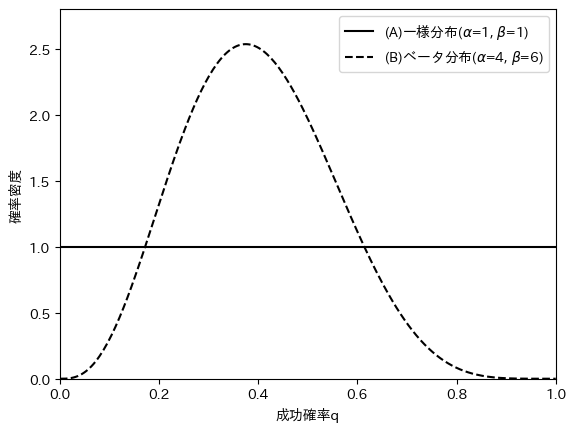

In [9]:
# 2.1
fig1 = plt.figure(num=1, facecolor='w')
q = np.linspace(0, 1, 250)
plt.plot(q, st.uniform.pdf(q), 'k-')
plt.plot(q, st.beta.pdf(q, 4, 6), 'k--')
plt.xlim(0, 1)
plt.ylim(0, 2.8)
plt.legend(['(A)一様分布($\\alpha$=1, $\\beta$=1)',  '(B)ベータ分布($\\alpha$=4, $\\beta$=6)'],  loc='best')
plt.xlabel('成功確率q')
plt.ylabel('確率密度')
plt.show()

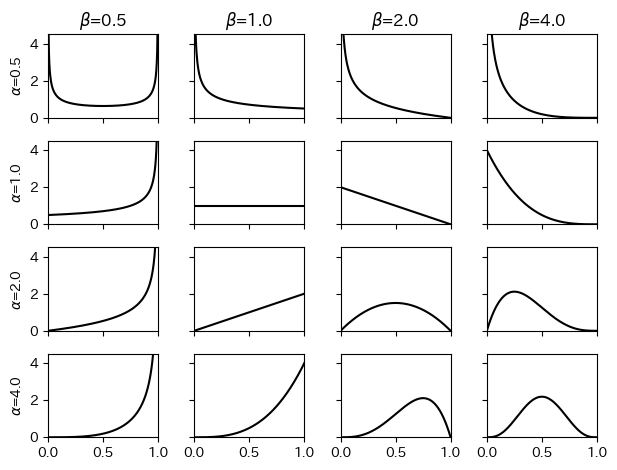

In [10]:
# 2.2
q = np.linspace(0, 1, 250)
value_a = np.array([0.5, 1.0, 2.0, 4.0])
value_b = np.array([0.5, 1.0, 2.0, 4.0])
rows = value_a.shape[0]
cols = value_b.shape[0]

fig, ax = plt.subplots(rows, cols, sharex='all', sharey='all', num=1, facecolor='w')
ax[0, 0].set_xlim(0.0, 1.0)
ax[0, 0].set_ylim(0.0, 4.5)
for row in range(rows):
    a = value_a[row]
    ax[row, 0].set_ylabel('$\\alpha$={0:3.1f}'.format(a))
    for col in range(cols):
        b = value_b[col]
        ax[row, col].plot(q, st.beta.pdf(q, a, b), 'k-')
        if row == 0:
            ax[0, col].set_title('$\\beta$={0:3.1f}'.format(b))

plt.tight_layout()
plt.show()

,平均,中央値,最頻値,標準偏差,信頼区間（下限）,信頼区間（上限）,HPD区間（下限）,HPD区間（上限）
成功確率 q,0.288462,0.285732,0.28,0.062231,0.17488,0.417448,0.190322,0.496747


----------
パラメータa0: 15.0
パラメータb0: 37.0
内閣支持率が50%以上であるという仮説の事後確率: 0.0008845985918934929
内閣支持率が50%以上であるという仮説の事後オッズ比: 0.0008853817993865183
----------


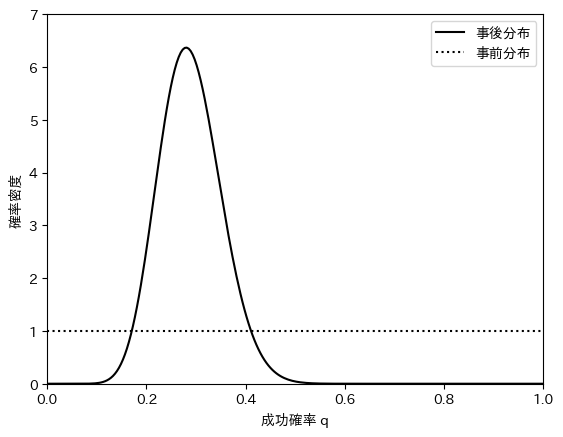

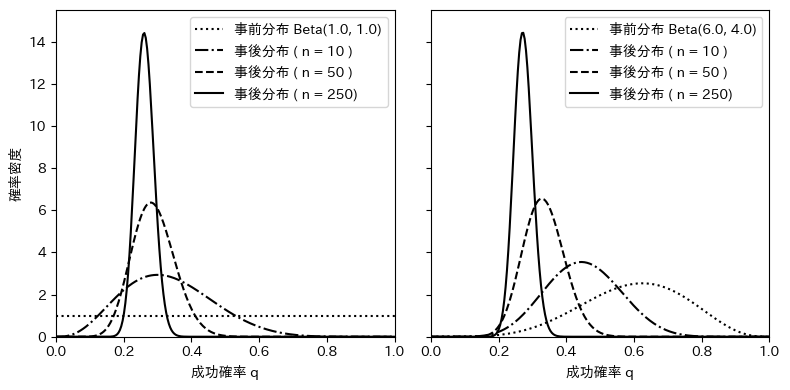

In [11]:
# 2.3
# ベータ分布のHPD区間の計算
def beta_hpdi(ci0, alpha, beta, prob):
    def hpdi_conditions(v, a, b, p):
        eq1 = st.beta.cdf(v[1], a, b) - st.beta.cdf(v[0], a, b) - p
        eq2 = st.beta.pdf(v[1], a, b) - st.beta.cdf(v[0], a, b)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, beta, prob)).x

# ベルヌーイ分布の成功確率の事後統計量の計算
def beronoui_stats(data, a0, b0, prob):
    n = data.size
    sum_data = data.sum()
    a = sum_data + a0
    b = n - sum_data + b0
    mean_pi = st.beta.mean(a, b)
    median_pi = st.beta.median(a, b)
    mode_pi = (a-1.0) / (a+b-2.0)
    sd_pi = st.beta.std(a, b)
    ci_pi = st.beta.interval(prob, a, b)
    hpdi_pi = beta_hpdi(ci_pi, a, b, prob)
    stats = np.hstack((mean_pi, median_pi, mode_pi, sd_pi, ci_pi, hpdi_pi))
    stats = stats.reshape((1, 8))
    stats_string = ['平均', '中央値', '最頻値', '標準偏差', '信頼区間（下限）', '信頼区間（上限）', 
                    'HPD区間（下限）', 'HPD区間（上限）']
    param_string = ['成功確率 q']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, a, b

# ベルヌーイ分布からのデータの生成
p = 0.25
n = 50
np.random.seed(99)
data = st.bernoulli.rvs(p, size=n)

# 事後統計量の計算
a0 = 1.0
b0 = 1.0
prob = 0.95
results, a, b = beronoui_stats(data, a0, b0, prob)
display(results)
print('----------')
print(f"パラメータa0: {a}")
print(f"パラメータb0: {b}")
print(f"内閣支持率が50%以上であるという仮説の事後確率: {1.0 - st.beta.cdf(0.5, a, b)}")
print(f"内閣支持率が50%以上であるという仮説の事後オッズ比: {(1.0 - st.beta.cdf(0.5, a, b)) / st.beta.cdf(0.5, a, b)}")
print('----------')

# 事後分布のグラフの作成
fig1 = plt.figure(num=1, facecolor='w')
q = np.linspace(0, 1, 250)
plt.plot(q, st.beta.pdf(q, a, b), 'k-', label='事後分布')
plt.plot(q, st.beta.pdf(q, a0, b0), 'k:', label='事前分布')
plt.xlim(0, 1)
plt.ylim(0, 7)
plt.xlabel('成功確率 q')
plt.ylabel('確率密度')
plt.legend(loc='best')
plt.show()

# 事前分布とデータの累積が事後分布の形状に与える影響の可視化
np.random.seed(99)
data = st.bernoulli.rvs(p, size=250)
value_size = np.array([10, 50, 250])
value_a0 = np.array([1.0, 6.0])
value_b0 = np.array([1.0, 4.0])
styles = [':', '-.', '--', '-']

fig2, ax2 = plt.subplots(1, 2, sharey='all', sharex='all', num=2, figsize=(8, 4), facecolor='w')
ax2[0].set_xlim(0, 1)
ax2[0].set_ylim(0, 15.5)
ax2[0].set_ylabel('確率密度')

for idx in range(2):
    style_index = 0
    a0_i = value_a0[idx]
    b0_i = value_b0[idx]
    ax2[idx].plot(q, 
                  st.beta.pdf(q, a0_i, b0_i), 
                  color='k', 
                  linestyle=styles[style_index], 
                  label='事前分布 Beta({0:<3.1f}, {1:<3.1f})'.format(a0_i, b0_i))
    for n_j in value_size:
        style_index += 1
        sum_data = np.sum(data[:n_j])
        a_j = sum_data + a0_i
        b_j = n_j - sum_data + b0_i
        ax2[idx].plot(q, 
                      st.beta.pdf(q, a_j, b_j), 
                      color='k', 
                      linestyle=styles[style_index], 
                      label='事後分布 ( n = {0:<3d})'.format(n_j))
    ax2[idx].set_xlabel('成功確率 q')
    ax2[idx].legend(loc='best')

plt.tight_layout()
plt.show()

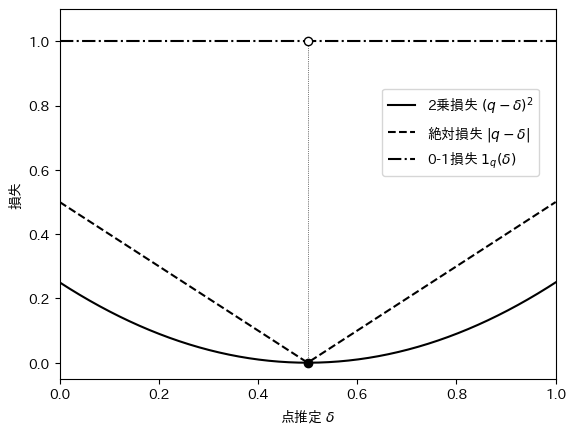

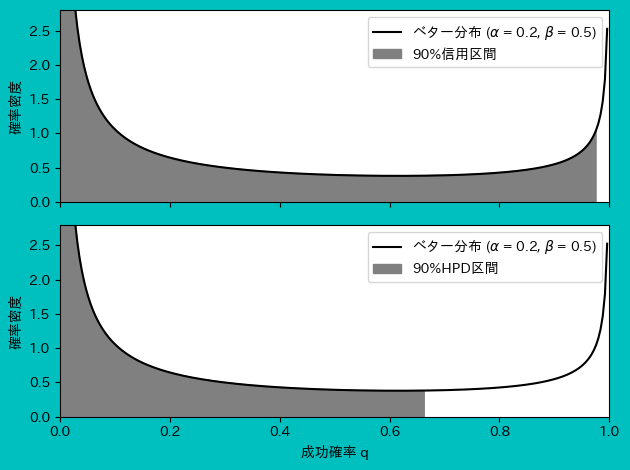

In [12]:
# 2.4
# ベータ分布のHPD区間の計算
def beta_hpdi(ci0, alpha, beta, prob):
    def hpdi_conditions(v, a, b, p):
        eq1 = st.beta.cdf(v[1], a, b) - st.beta.cdf(v[0], a, b) - p
        eq2 = st.beta.pdf(v[1], a, b) - st.beta.cdf(v[0], a, b)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, beta, prob)).x

# 損失関数のグラフ
q = np.linspace(0, 1, 250)
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(q, (q-0.5)**2, 'k-', label='2乗損失 $(q-\\delta)^2$')
plt.plot(q, np.abs(q-0.5), 'k--', label='絶対損失 $|q-\\delta|$')
plt.axhline(y=1, color='k', linestyle='-.', label='0-1損失 $1_{q}(\\delta)$')
plt.plot([0.5, 0.5], [0, 1], 'k:', linewidth=0.5)
plt.plot(0.5, 0, marker='o', mec='k', mfc='k')
plt.plot(0.5, 1, marker='o', mec='k', mfc='w')
plt.xlim(0, 1)
plt.ylim(-0.05, 1.1)
plt.xlabel('点推定 $\\delta$')
plt.ylabel('損失')
plt.legend(loc=(0.65, 0.55))
plt.show()

# 信用区間とHPD区間の比較
a = 0.2
b = 0.5
prob = 0.9
ci = st.beta.interval(prob, a, b)
hpdi = beta_hpdi(ci, a, b, prob)
q = np.linspace(0, 1, 250)
qq = [np.linspace(ci[0], ci[1], 250), np.linspace(hpdi[0], hpdi[1], 250)]
label1 = 'ベター分布 ($\\alpha$ = {0:<3.1f}, $\\beta$ = {1:<3.1f})'.format(a, b)
label2 = ['信用区間', 'HPD区間']

fig2, ax2 = plt.subplots(2, 1, sharex='all', sharey='all', num=2, facecolor='c')
ax2[1].set_xlim(0, 1)
ax2[1].set_ylim(0, 2.8)
ax2[1].set_xlabel('成功確率 q')
for idx in range(2):
    plot_label = '{0:2.0f}%{1:s}'.format(100*prob, label2[idx])
    ax2[idx].plot(q, st.beta.pdf(q, a, b), 'k-', label=label1)
    ax2[idx].fill_between(qq[idx], st.beta.pdf(qq[idx], a, b), color='0.5', label=plot_label)
    ax2[idx].axhline(y=st.beta.pdf(hpdi[0], a, b), color='k', linestyle='-', linewidth=0.5)
    ax2[idx].set_ylabel('確率密度')
    ax2[idx].legend(loc='upper right')
plt.tight_layout()
plt.show()